In [13]:
from PIL import Image
from skimage.io import imread
from skimage.transform import rescale, resize
import os
import glob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import applications
import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sn
import shutil
import random
import cv2

In [2]:
#use this to delete the dataset folder if needed
#shutil.rmtree('dataset')


In [3]:
try:
    os.mkdir('dataset')
    os.mkdir('dataset/training')
    os.mkdir('dataset/testing')
except OSError as error:
    pass

In [4]:
path  = "data/blnw-images-224"
#os.chdir(path)
category_list=os.listdir(path)
category_list


['bolt', 'locatingpin', 'nut', 'washer']

In [5]:
os.getcwd()

'E:\\Mech-parts-classification-seq-model'

In [6]:

os.getcwd()
train_path = 'dataset/training'
test_path = 'dataset/testing'
try:
    for i in category_list:
        os.mkdir(train_path + '/' + i)
        
except OSError as e:
    print(e)
    
try:
    for i in category_list:
        os.mkdir(test_path + '/' + i)
        
except OSError as e:
    print(e)
    


[WinError 183] Cannot create a file when that file already exists: 'dataset/training/bolt'
[WinError 183] Cannot create a file when that file already exists: 'dataset/testing/bolt'


In [7]:

src = glob.glob(path+'/*')
test_dst = glob.glob(test_path +"/*")
train_dst = glob.glob(train_path + '/*')



In [8]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE , filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]
    
    for filename in training_set:
        
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING , filename)
        image = cv2.imread(this_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        cv2.imwrite(destination,image)
        #shutil.copy(this_file, destination)
        
    for filename in testing_set:
        this_file = os.path.join(SOURCE , filename)
        destination = os.path.join(TESTING , filename)
        image = cv2.imread(this_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        cv2.imwrite(destination,image)
       



In [9]:
# split_size = .8
# for i,j,z in zip(src,train_dst,test_dst):
#     split_data(i,j,z, split_size)


In [10]:
for i,j,z in zip(src,train_dst,test_dst):
    print(i,'\t',j,'\t',z,'\n')

data/blnw-images-224\bolt 	 dataset/training\bolt 	 dataset/testing\bolt 

data/blnw-images-224\locatingpin 	 dataset/training\locatingpin 	 dataset/testing\locatingpin 

data/blnw-images-224\nut 	 dataset/training\nut 	 dataset/testing\nut 

data/blnw-images-224\washer 	 dataset/training\washer 	 dataset/testing\washer 



# Sequential

In [16]:
#Creation of a CNN . Sequential Model

model = Sequential()
#input_shape matches our input image
model.add(Conv2D(64, (3,3), input_shape=(224, 224, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(4)) #data of four types
model.add(Activation('softmax'))

model.compile(loss= keras.losses.categorical_crossentropy, 
              optimizer= Adam(),metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)       

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,
        rescale = 1./255,
        validation_split = 0.2
        )  


In [19]:

test_datagen = ImageDataGenerator(rescale = 1./255 )

In [20]:
# # Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'training',
                                            shuffle = True)

Found 4876 images belonging to 4 classes.


In [21]:
val_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'validation',
                                            shuffle = True)

Found 1216 images belonging to 4 classes.


In [22]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1524 images belonging to 4 classes.


In [23]:
history = model.fit(
  training_set,
  validation_data= test_set,
  epochs= 50,
  shuffle = True,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
  
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 153 steps, validate for 48 steps
Epoch 1/50
153/153 [==============================] - 101s 657ms/step - loss: 1.3432 - accuracy: 0.3587 - val_loss: 1.1347 - val_accuracy: 0.5650
Epoch 2/50
153/153 [==============================] - 44s 288ms/step - loss: 1.1452 - accuracy: 0.5018 - val_loss: 0.8488 - val_accuracy: 0.6240
Epoch 3/50
153/153 [==============================] - 45s 295ms/step - loss: 0.9809 - accuracy: 0.5814 - val_loss: 0.7621 - val_accuracy: 0.6660
Epoch 4/50
153/153 [==============================] - 46s 298ms/step - loss: 0.8589 - accuracy: 0.6167 - val_loss: 0.7281 - val_accuracy: 0.6929
Epoch 5/50
153/153 [==============================] - 46s 302ms/step - loss: 0.8911 - accuracy: 0.6237 - val_loss: 0.8214 - val_accuracy: 0.6640
Epoch 6/50
153/153 [==============================] - 47s 305ms/step - loss: 0.7573 - accuracy: 0.6749 - val_loss: 0.6437 - val_accuracy: 0.7270
Epoch 7/50
153/153 [================

In [24]:
model.evaluate(test_set)

  ...
    to  
  ['...']
48/48 [==============================] - 3s 54ms/step - loss: 0.1963 - accuracy: 0.9291


[0.19626732108493647, 0.92913383]

In [25]:
model.save('mech2.h5')

In [ ]:
history.history

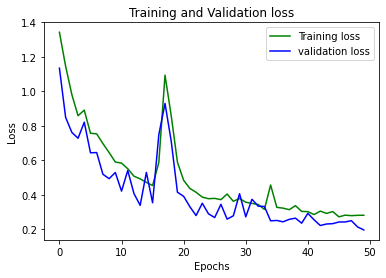

<Figure size 432x288 with 0 Axes>

In [32]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(1,no_epochs+1)
plt.plot( loss_train, 'g', label='Training loss')
plt.plot( loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('train-val loss')

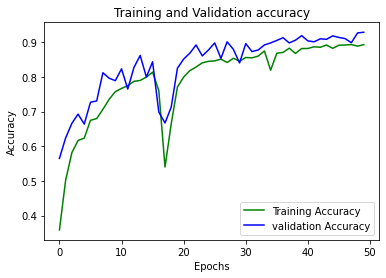

<Figure size 432x288 with 0 Axes>

In [31]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
#epochs = range(1,no_epochs+1)
plt.plot( loss_train, 'g', label='Training Accuracy')
plt.plot( loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('train-val-accuracy')